In [4]:
import numpy as np 
import pandas as pd
import os, time, sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten # type: ignore

import dnn
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Definition of different Models

Here I define some simple models which can be extended as desired.

# A Single Layer - Models with different Loss


In [5]:
def get_model_FFT(x, y, Dmeta, loss, metric, detector, z = 30, lam = 1, Nmeta = 56, SHG = False, embedding = 0, lr = 0.001):
    
    # Padding input to match computational domain
    N = len(x)
    pad = int((N - 28) // 2)
    padding = [[0, 0], [pad, pad], [pad, pad]]

    # Define the Model
    input_layer = Input(shape=(28, 28))
    out = tf.pad(input_layer, padding)  #out output will be of the size of the padded input layer
    out = tf.cast(out, tf.complex64)  #we set that the output will be complex
    out = dnn.opticalFFT(x=x, y=y, lam=lam, f=None)(out)
    out = dnn.Meta(x=x, y=y, lam=lam, Dx_meta=Dmeta, Dy_meta=Dmeta, N_Neurons=Nmeta, embedding=embedding)(out)
    if SHG:
        # Per default the method used for propagation is RS.Sommerfield, You can choose altrnatives, I only recommend Angular spectrum (which) is implemented as well
        # for the near field
        out = dnn.FreeSpacePropagation(x=x, y=y, z=z, lam=lam)(out)
        out = dnn.Activation.SHG(out)
    out  = dnn.opticalFFT(x=x, y=y, lam=lam, f=None)(out)
    output_layer = dnn.ToDetector(detector)(out)

    # Build the model
    model = Model(inputs=input_layer, outputs=output_layer, name="model")

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=loss,
        metrics=[metric]
    )
    return model


Shape of Training and test Data
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
Number of classes 10

After one Hot encoding of test labels, with and without mock class
(60000, 11) (60000, 10)


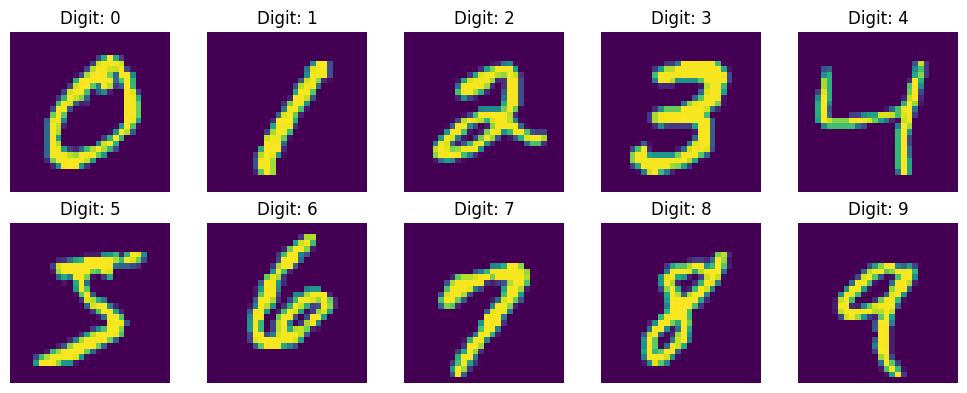

In [6]:
import importlib
importlib.reload(dnn)

# Load datasets
x_train, y_train, x_test, y_test = dnn.loadData("digits") # alternatives are "fashion", "emnist"
print("\nShape of Training and test Data")
print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))

# Convert to One Hot vectors
# For Certain Losses One Hot encoding might be required, you can transform the vectors to one hot encoded ones with
num_classes = len(np.unique(y_test))
print(f"Number of classes {num_classes}")
y_train_oneHot_withMock = tf.one_hot(tf.cast(y_train,tf.int32), depth=num_classes+1)
y_test_oneHot_withMock  = tf.one_hot(tf.cast(y_test,tf.int32), depth=num_classes+1)
y_train_oneHot_noMock = tf.one_hot(tf.cast(y_train,tf.int32), depth=num_classes)
y_test_oneHot_noMock  = tf.one_hot(tf.cast(y_test,tf.int32), depth=num_classes)
print("\nAfter one Hot encoding of test labels, with and without mock class")
print(np.shape(y_train_oneHot_withMock), np.shape(y_train_oneHot_noMock ))
# Collect one sample per digit
unique_digits = {label: x_train[np.where(y_train == label)[0][0]] for label in range(10)}
# Plot in a 2x5 grid
plt.figure(figsize=(10, 4))
for i, (label, img) in enumerate(unique_digits.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze())
    plt.title(f"Digit: {label}")
    plt.axis('off')
    if i==9:
        break
plt.tight_layout()
plt.show()


For propagation distances something around 30 wavelength performs well.
This paper discusses the parameter in detail:
- Minjia Zheng, Lei Shi, and Jian Zi, "Optimize performance of a diffractive neural network by controlling the Fresnel number,"
   <br> Photon. Res. 10, 2667-2676 (2022)
  <br> https://opg.optica.org/prj/fulltext.cfm?uri=prj-10-11-2667&id=513693


In [7]:
# Choose Model parameters
lam  = 1
D    = 140                             # Here I define Everything in units of lambda, but real units can be used
N    = 2*D                             # Use 2 points per lambda for far-field propagation (more if you look at the near field o correctly show high frequency components)
x = y = np.linspace(-D/2, D/2, N)      # This defines the computational domain 
Dmeta =  0.4*D                         # The metasurface will outomatically be embedded into the computational domain
pixelsize = 1*lam                      # make sure that the pixelsize is not smaller than the sampling, it is best to choose a common multiple to avoid any interpolation
Nmeta = int(Dmeta/pixelsize)      
embedding = 0       
print("Numer of Neurons:", Nmeta)    


Numer of Neurons: 56


k:\kartashova\phd\ONN\projects\anna\dnns\LeoProject/detector_masks\10_classes_standard.npy


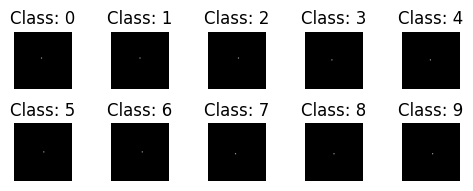

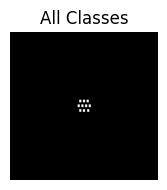

In [8]:
import importlib
importlib.reload(dnn)

# Define the detector
# you can use an image as detector and embedd it in the computational domain
DDet     = 28/N*D 
file     = os.path.join(os.getcwd(),'LeoProject/detector_masks',"10_classes_standard.npy")
print(file)
detector = dnn.loadDetector(Dx = DDet, Dy = DDet, x = x, y = y, file = file)

# Assuming detector shape is (n_classes, height, width)
n_classes = detector.shape[0]
fig, axes = plt.subplots(2, n_classes//2, figsize=( n_classes//2, 2))  # Adjust size as needed
for idx, (ax, d) in enumerate(zip(axes.flatten(), detector)):
    ax.imshow(d, cmap='gray')
    ax.set_title(f"Class: {idx}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Plot the sum over all classes
plt.figure(figsize =(2,2))
plt.imshow(np.sum(detector, axis=0), cmap='gray')  # sum over class axis
plt.axis('off')
plt.title("All Classes")
plt.tight_layout()
plt.show()





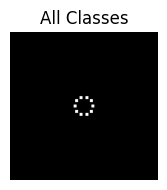

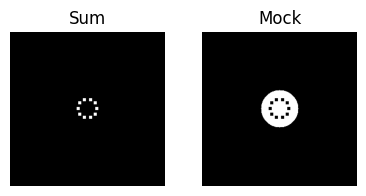

In [13]:
importlib.reload(dnn)
# Or use this custom Class that arranges the Patches symmetrically around the center
N         = len(x)
nClasses  = 10 
angles    = np.linspace(0,360-360/nClasses, nClasses)
r_patches = 0.12
size      = 6
detector  = dnn.makeDetector(angles, size, r_patches, N=N, mock = False)

plt.figure(figsize =(2,2))
plt.imshow(np.sum(detector, axis = 0), cmap='gray')
plt.axis('off')
plt.title(f"All Classes")
plt.tight_layout()
plt.show()

# You can Introduce a mock class whcih helps penalizing light that is inbetween detectors
# This helps with contrast but pnealized accuracy
N         = len(x)
nClasses  = 10 
angles    = np.linspace(0,360-360/nClasses, nClasses)
r_patches = 0.12
size      = 6
detector  = dnn.makeDetector(angles, size, r_patches, N=N, mock = True, penalty = 10)

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(np.sum(detector[:-1], axis=0), cmap='gray')
axes[0].set_title("Sum")
axes[0].axis('off')
axes[1].imshow(detector[-1], cmap='gray')
axes[1].set_title("Mock")
axes[1].axis('off')
plt.tight_layout()
plt.show()


# Example model

In [52]:
# Define and Look at model

# I usually use RSP to propgate light, for near field ASM might be more suited, see doc_propagation for that
# The from_logits_True means that sigmoid is applied

# For non one-hot encoded Classes
loss            = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metric          = tf.keras.metrics.SparseCategoricalAccuracy() #the first class is 0 and so on

# For one-hot encoded Classes
'''loss            = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric          = tf.keras.metrics.CategoricalAccuracy()'''

DDet     = 28/N*D 
file     = os.path.join(os.getcwd(),'LeoProject/detector_masks',"10_classes_standard.npy")
detector = dnn.loadDetector(Dx = DDet, Dy = DDet, x = x, y = y, file = file)

tf.keras.backend.clear_session()
model = get_model_FFT(x = x, y = y, Dmeta = Dmeta, loss = loss, metric = metric, detector = detector, z = 30, lam = 1, Nmeta = 56, SHG = False, embedding = 0, lr = 0.001)
model.summary() #look at the model, shows parameters amplitudes and phases

280 112
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.compat.v1.pad (TFOpLamb  (None, 280, 280)          0         
 da)                                                             
                                                                 
 tf.cast (TFOpLambda)        (None, 280, 280)          0         
                                                                 
 optical_fft (opticalFFT)    (None, 280, 280)          0         
                                                                 
 meta (Meta)                 (None, 280, 280)          6272      
                                                                 
 optical_fft_1 (opticalFFT)  (None, 280, 280)          0         
                                                     

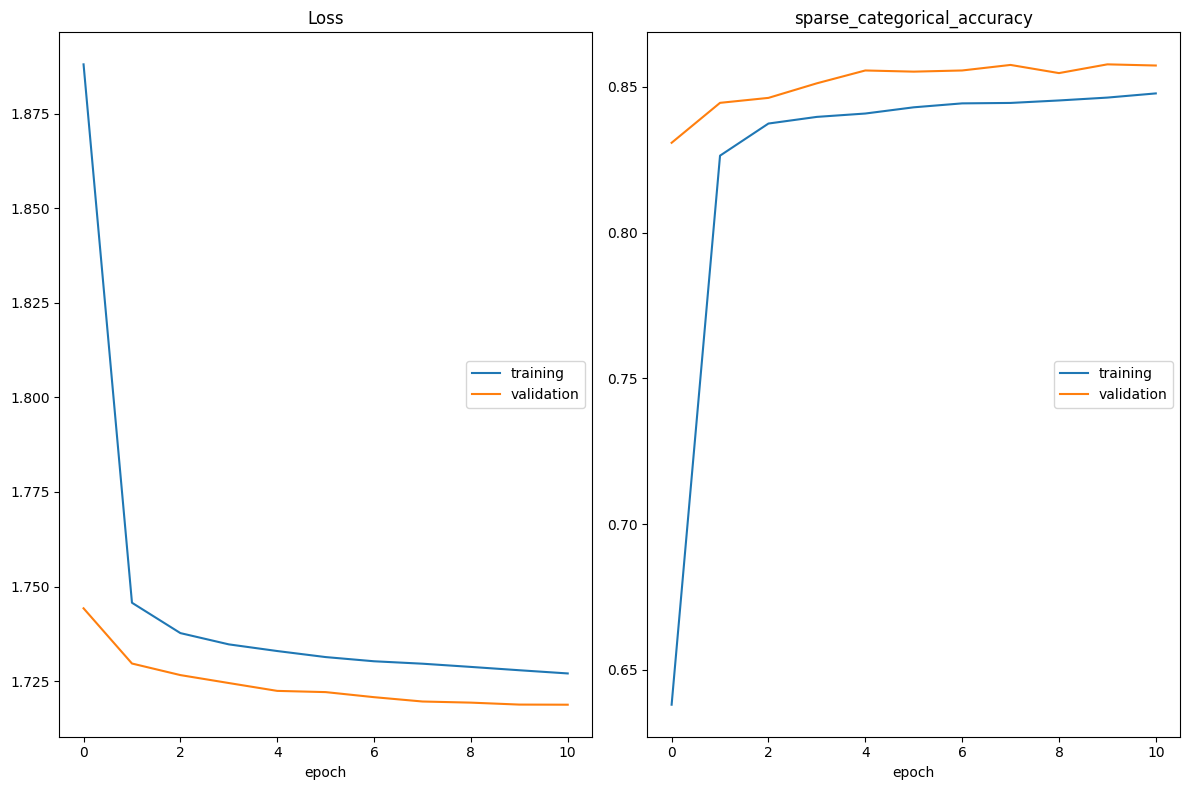

Loss
	training         	 (min:    1.727, max:    1.888, cur:    1.727)
	validation       	 (min:    1.719, max:    1.744, cur:    1.719)
sparse_categorical_accuracy
	training         	 (min:    0.638, max:    0.848, cur:    0.848)
	validation       	 (min:    0.831, max:    0.858, cur:    0.857)
2400/2400 [==============================] - 370s 154ms/step - loss: 1.7270 - sparse_categorical_accuracy: 0.8477 - val_loss: 1.7188 - val_sparse_categorical_accuracy: 0.8573
The training required:	 4488.5962789058685 s


In [55]:
# Training with sparse categorical accuracy Loss, no SHG
# For non one-hot encoded Classes
tf.keras.backend.clear_session()

loss            = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metric          = tf.keras.metrics.SparseCategoricalAccuracy()
model           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector, 
                                z = 30, lam = 1, Nmeta = 60, 
                                SHG = False, embedding = 0, lr = 0.001)
#Train Model
epochs = 50
from livelossplot import PlotLossesKeras

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
monitor='val_sparse_categorical_accuracy',     # or 'accuracy' if you only use training data
patience=3,                 # how many epochs to wait after last improvement
min_delta=0.001,            # minimum change to qualify as improvement
restore_best_weights=True  # restore weights from the best epoch
)
batch_size = 25 #will average over the losses of the batches and adapt the weights
#8 images at once , to make it faster make it larger
t = time.time()
history        = model.fit(x_train, y_train ,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    callbacks=[PlotLossesKeras(), early_stopping],
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")

### Plotting the accuracies

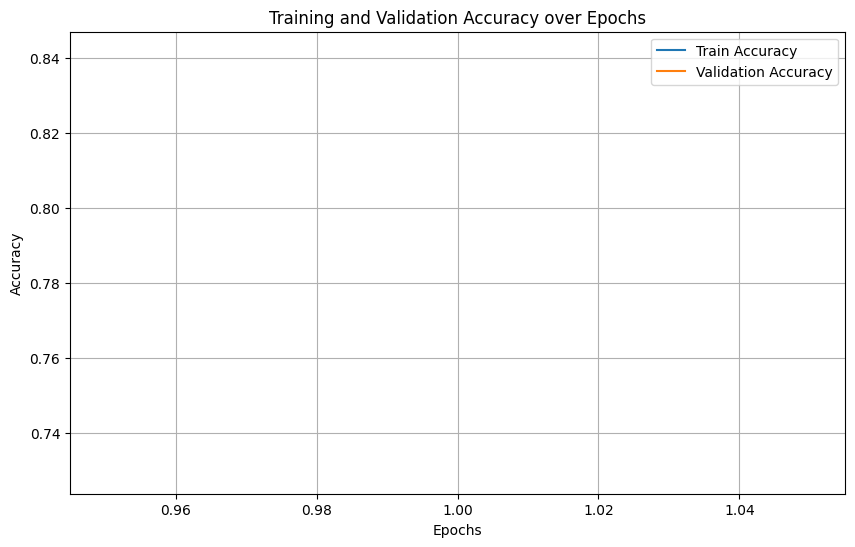

In [13]:
train_accuracy=history.history['sparse_categorical_accuracy']
val_accuracy=history.history['val_sparse_categorical_accuracy']
epoch_array=np.arange(1, epochs+1)
plt.figure(figsize=(10, 6))
plt.plot(epoch_array, train_accuracy, label='Train Accuracy')
plt.plot(epoch_array, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Training with sparse categorical accuracy Loss, Lets Try twice as many neurons
# For non one-hot encoded Classes
tf.keras.backend.clear_session()
loss            = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metric          = tf.keras.metrics.SparseCategoricalAccuracy()
model           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector, 
                                z = 30, lam = 1, Nmeta = 120, 
                                SHG = False, embedding = 0, lr = 0.001)
#Train Model
epochs = 1
batch_size = 8
t = time.time()
history        = model.fit(x_train, y_train ,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")

300 120
7500/7500 [==============================] - 180s 24ms/step - loss: 1.0610 - sparse_categorical_accuracy: 0.7074 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8751
The training required:	 180.67377305030823 s


In [9]:
# Training with sparse categorical accuracy Loss, no SHG
# For non one-hot encoded Classes
loss            = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metric          = tf.keras.metrics.SparseCategoricalAccuracy()
model           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector, 
                                z = 30, lam = 1, Nmeta = 56, 
                                SHG = True, embedding = 0, lr = 0.001)
#Train Model
epochs = 1
batch_size = 8
t = time.time()
history        = model.fit(x_train, y_train ,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")

280 112

 732/7500 [=>............................] - ETA: 5:35 - loss: 2.1067 - sparse_categorical_accuracy: 0.3301

KeyboardInterrupt: 

# MSE Loss and Transferring models

MSE Loss tends to show better class contrast but worse accuracy.
- Minjia Zheng, Lei Shi, and Jian Zi, "Optimize performance of a diffractive neural network by controlling the Fresnel number," Photon. Res. 10, 2667-2676 (2022)
  <br> https://opg.optica.org/prj/fulltext.cfm?uri=prj-10-11-2667&id=513693

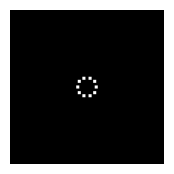

In [67]:
# I change the detector to the circular one
# This one works way better for training compared to the other detector with MSE loss 
N         = len(x)
nClasses  = 10 
angles    = np.linspace(0,360-360/nClasses, nClasses)
r_patches = 0.12
size      = 6
detector  = dnn.makeDetector(angles, size, r_patches, N=N, mock = False)

plt.figure(figsize=(2,2))
plt.imshow(np.sum(detector, axis = 0), cmap = "grey")
plt.axis("off")
plt.show()

In [68]:
# No Lets Try with vectorial MSE Loss
# Training with sparse categorical accuracy Loss, no SHG

# For non one-hot encoded Classes
tf.keras.backend.clear_session()
loss            = tf.keras.losses.MeanSquaredError()
metric          = tf.keras.metrics.CategoricalAccuracy()
model           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector, 
                                z = 30, lam = 1, Nmeta = 60, 
                                SHG = False, embedding = 0, lr = 0.001)
#Train Model
epochs = 1
batch_size = 8
t = time.time()
history        = model.fit(x_train, y_train_oneHot_noMock ,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    validation_data = (x_test, y_test_oneHot_noMock ))
print("The training required:\t", time.time()-t, "s")

# Get Phasemask
weights = model.get_weights()


300 120
7500/7500 [==============================] - 221s 29ms/step - loss: 0.0502 - categorical_accuracy: 0.8096 - val_loss: 0.0449 - val_categorical_accuracy: 0.8657
The training required:	 222.2061185836792 s


### Visualizing the weights

In [36]:
# Example: Visualizing amplitude and phase masks from weights
# The model can in principle train both amplitude and phase masks. 
# Here, I assume amplitude is not trainable.
weights = model.get_weights()

# Set up subplots
plt.figure(figsize=(10, 4))
cmap = 'twilight'  # Good for phase-like visualization
for i, w in enumerate(weights):
    plt.subplot(1, len(weights), i + 1)
    plt.imshow(w, cmap=cmap)
    title = "Phase" if i == 0 else "Amplitude"
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

In [23]:
# Validate Model
loss            = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metric          = tf.keras.metrics.SparseCategoricalAccuracy()
model_validate           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector, 
                                z = 30, lam = 1, Nmeta = 60, 
                                SHG = True, embedding = 0, lr = 0.001)

# Compute Accuracy
print("The model is untrained and thus performance is poor")
model_validate .evaluate(x_train[:500], y_train[:500])
model_validate .evaluate(x_test[:500], y_test[:500])

# Transfer Weights to new model
model_validate.set_weights(weights)

# Compute Accuracy
print("Affter transfering weights performance is better")
model_validate.evaluate(x_train[:500], y_train[:500])
model_validate.evaluate(x_test[:500], y_test[:500])

300 120
The model is untrained and thus performance is poor
16/16 [==============================] - 2s 129ms/step - loss: 2.3046 - sparse_categorical_accuracy: 0.0780
Affter transfering weights performance is better
16/16 [==============================] - 2s 129ms/step - loss: 2.2526 - sparse_categorical_accuracy: 0.2000


[2.2525577545166016, 0.20000000298023224]

# Vizualize the Field

To look at intermediate layers, we need to define intermediate mdoels and read the output.


In [46]:

def plotFields(model, testImages ,planes,  detector,  zoom = 120):

    # Compute field at detector
    layers = model.layers
    outputs = []
    for layer_index in planes:
        intermediate_model = Model(inputs=model.input, outputs=layers[layer_index].output)
        outputs.append(np.abs(intermediate_model.predict(testImages , verbose = False))**2)
    
    temp = outputs[-1]*np.sum(detector, axis = 0)
    outputs.append(temp[:,zoom:-zoom,zoom:-zoom])

    fig, axes = plt.subplots(len(testImages), len(outputs), figsize=(13, 2*len(testImages)))
    for i in range(len(outputs)):
        for j in range(len(testImages)):  
            ax = axes[j, i]
            im = ax.imshow(outputs[i][j])
            ax.axis("off")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

Note that we tarined with a circular detector, by multiplying with the detector which has zeros in the center we remove information about that area, hence, accuracy and class contrast is good but efficiency is bad. I.E lots of light goes right into he center.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.compat.v1.pad (TFOpLamb  (None, 280, 280)          0         
 da)                                                             
                                                                 
 tf.cast (TFOpLambda)        (None, 280, 280)          0         
                                                                 
 optical_fft (opticalFFT)    (None, 280, 280)          0         
                                                                 
 meta (Meta)                 (None, 280, 280)          7200      
                                                                 
 optical_fft_1 (opticalFFT)  (None, 280, 280)          0         
                                                             

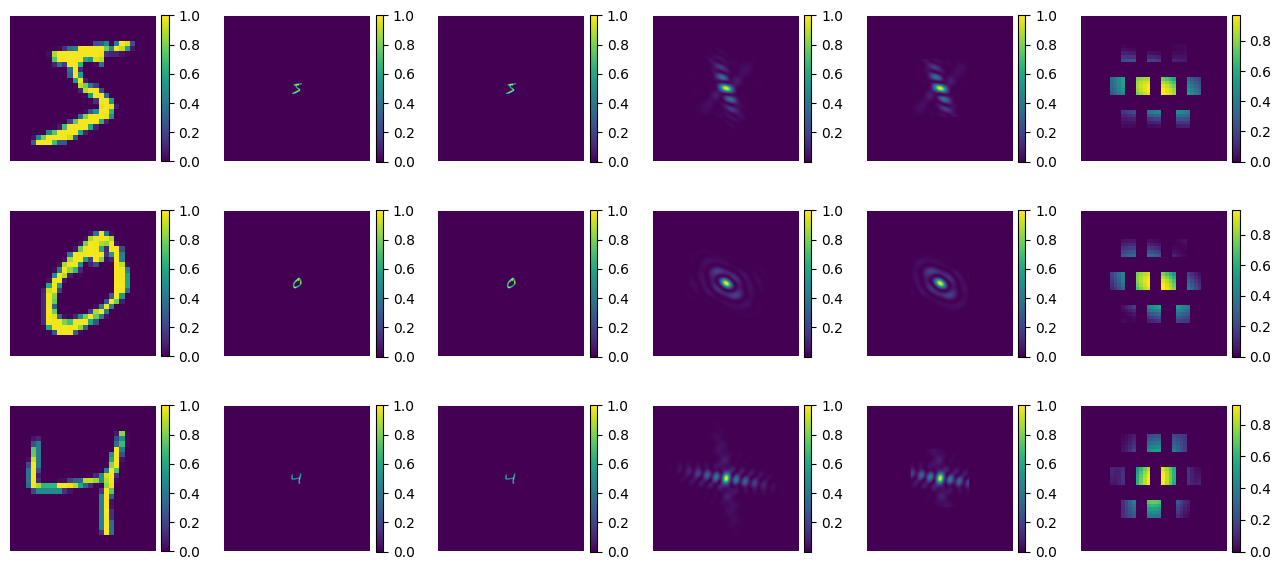

In [57]:
model.summary()
testImages = np.array([x_train[i] for i in [0,1,2]])
planes     = [0,1,2,3,4]
plotFields(model, testImages, planes,  detector,  zoom = 120)

# Train with a mock class
During Training teh Accuracy cannot be computed correctly (as some classes will be falsely classified as the mock class)

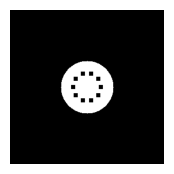

In [136]:
# I change the detector to the circular one
# This one works way better for training compared to the other detector with MSE loss 
N         = len(x)
nClasses  = 10 
angles    = np.linspace(0,360-360/nClasses, nClasses)
r_patches = 0.18
size      =8
detector  = dnn.makeDetector(angles, size, r_patches, N=N, mock = True, penalty = 7)

plt.figure(figsize=(2,2))
plt.imshow(detector[-1], cmap = "grey")
plt.axis("off")
plt.show()

In [137]:
# No Lets Try with vectorial MSE Loss
# Training with sparse categorical accuracy Loss, no SHG

# For non one-hot encoded Classes
tf.keras.backend.clear_session()
loss            = tf.keras.losses.MeanSquaredError()
metric          = tf.keras.metrics.CategoricalAccuracy()
model           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector, 
                                z = 30, lam = 1, Nmeta = 120, 
                                SHG = False, embedding = 0, lr = 0.001)
#Train Model
epochs = 1
batch_size = 8
t = time.time()
history        = model.fit(x_train, y_train_oneHot_withMock ,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    validation_data = (x_test, y_test_oneHot_withMock ))
print("The training required:\t", time.time()-t, "s")

# Get Phasemask
weights = model.get_weights()


300 120
7500/7500 [==============================] - 228s 30ms/step - loss: 0.5239 - categorical_accuracy: 0.0000e+00 - val_loss: 0.4070 - val_categorical_accuracy: 0.0000e+00
The training required:	 228.7159240245819 s


Now we need the validation with another model to get the true accuracy with the right number of classes.

In [139]:
# Validate Model
loss            = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metric          = tf.keras.metrics.SparseCategoricalAccuracy()
model_validate           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector[:-1], #Here to validate I remove Last Class of Detector
                                z = 30, lam = 1, Nmeta = 120, 
                                SHG = False, embedding = 0, lr = 0.001)

# Compute Accuracy
print("The model is untrained and thus performance is poor")
model_validate .evaluate(x_train[:500], y_train[:500])
model_validate .evaluate(x_test[:500], y_test[:500])

# Transfer Weights to new model
model_validate.set_weights(weights)

# Compute Accuracy
print("Affter transfering weights performance is better")
model_validate.evaluate(x_train[:500], y_train[:500])
model_validate.evaluate(x_test[:500], y_test[:500])

300 120
The model is untrained and thus performance is poor
16/16 [==============================] - 1s 37ms/step - loss: 2.3023 - sparse_categorical_accuracy: 0.1040
Affter transfering weights performance is better
16/16 [==============================] - 1s 38ms/step - loss: 2.2618 - sparse_categorical_accuracy: 0.2880


[2.261791467666626, 0.2879999876022339]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.compat.v1.pad (TFOpLamb  (None, 300, 300)          0         
 da)                                                             
                                                                 
 tf.cast (TFOpLambda)        (None, 300, 300)          0         
                                                                 
 optical_fft (opticalFFT)    (None, 300, 300)          0         
                                                                 
 meta (Meta)                 (None, 300, 300)          28800     
                                                                 
 optical_fft_1 (opticalFFT)  (None, 300, 300)          0         
                                                             

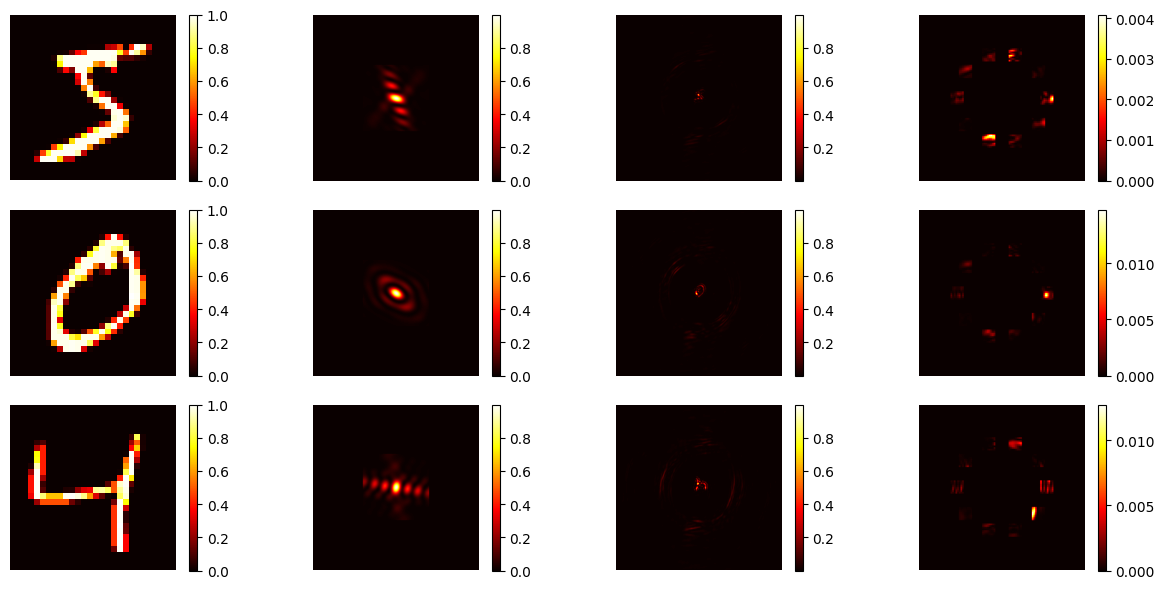

In [142]:
model.summary()
testImages = np.array([x_train[i] for i in [0,1,2]])
planes     = [0,4,5]
plotFields(model, testImages, planes,  detector[:-1],  zoom = 100)

## Pixelwise MSE Loss
Here I define the MSE Loss as the difference of the Output Image to the Traget Image.
However, as you see the training does not really work properly.
For the Metric I use Accuracy, which I have to define sperately here.

In [37]:
from functools import partial
def get_model(x, y, loss, metric, Dmeta , detector, z = 30, lam = 1, Nmeta = 56, SHG = False, embedding = 0, lr = 0.001):
    
    # Padding input to match computational domain
    N = len(x)
    pad = int((N - 28) // 2)
    padding = [[0, 0], [pad, pad], [pad, pad]]

    # Define the Model
    input_layer = Input(shape=(28, 28))
    out = tf.pad(input_layer, padding)
    out = tf.cast(out, tf.complex64)
    out = dnn.opticalFFT(x=x, y=y, lam=lam, f=None)(out)
    out = dnn.Meta(x=x, y=y, lam=lam, Dx_meta=Dmeta, Dy_meta=Dmeta, N_Neurons=Nmeta, embedding=embedding)(out)
    if SHG:
        out = dnn.FreeSpacePropagation(x=x, y=y, z=z, lam=lam)(out)
        out = dnn.Activation.SHG(out)
    output_layer  = dnn.opticalFFT(x=x, y=y, lam=lam, f=None)(out)

    # Build the model
    model = Model(inputs=input_layer, outputs=output_layer, name="model")

    # Compile Model
    loss     = partial(custom_mse_loss, detector = detector)
    metric    = CustomSparseCategoricalAccuracy(detector)

    print(output_layer)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss      =  loss, metrics=[metric] 
    )
    return model

def custom_mse_loss(output_label, output_layer, detector):
    tf.print(output_layer)
    readout  = Flatten()(tf.abs(output_layer)**2)  
    print(readout)                   # Compute intensity and Flatten (Batch, NxN)
    detector = Flatten()(detector)                                    # Flatten detector (nClasses, NxN)
    norm     = tf.reduce_max(readout, axis=-1, keepdims=True)         # Normalize each output to maximally 1
    readout  = readout / norm                                         # Prevent divide-by-zero
    readout  = tf.cast(readout, dtype=np.float64)     
    detector = tf.cast(detector , dtype=np.float64)                # Cast to same type (float) as detector, tensorflow is REALLY whiny about datatypes                                        
    selected_detectors = tf.gather(detector, output_label)   
    print(selected_detectors)         # Select the targetimage by label, selected detectors is now of shape (Batch, NxN)
    loss     = tf.reduce_mean(tf.square(readout - selected_detectors), axis = -1) # Computes MSE-difference (Batch)
    return tf.reduce_mean(loss)       
                                          # averages over batch
class CustomSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, detector, name='custom_sparse_categorical_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.detector = Flatten()(detector )# Flatten if needed
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute readout
        readout = tf.abs(y_pred) ** 2
        readout = tf.reshape(readout, [tf.shape(readout)[0], -1])
        readout = tf.cast(readout, dtype=self.detector.dtype)
        readout = tf.matmul(readout, tf.transpose(self.detector))

        # Normalize
        norm = tf.reduce_max(readout, axis=-1, keepdims=True)
        readout = readout / (norm + 1e-8)

        # Compute accuracy
        acc = tf.keras.metrics.sparse_categorical_accuracy(y_true, readout)

        self.total.assign_add(tf.reduce_sum(acc))
        self.count.assign_add(tf.cast(tf.size(acc), self.count.dtype))

    def result(self):
        return self.total / (self.count + 1e-8)

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    def get_config(self):
        config = super().get_config()
        # add your custom args if any
        return config   



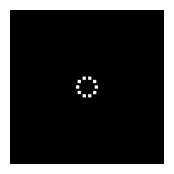

In [16]:
# I change the detector to the circular one
# This one works way better for training compared to the other detector with MSE loss 
N         = len(x)
nClasses  = 10 
angles    = np.linspace(0,360-360/nClasses, nClasses)
r_patches = 0.12
size      = 6
detector  = dnn.makeDetector(angles, size, r_patches, N=N, mock = False)

plt.figure(figsize=(2,2))
plt.imshow(np.sum(detector, axis = 0), cmap = "grey")
plt.axis("off")
plt.show()

In [36]:
# No Lets Try with pixelwise
y_train = y_train.astype(np.int16)
y_test = y_test.astype(np.int16)
tf.keras.backend.clear_session()
loss            = tf.keras.losses.MeanSquaredError()
metric          = tf.keras.metrics.CategoricalAccuracy()
model           = get_model(x = x, 
                            y = y, 
                            Dmeta = Dmeta, 
                            loss = loss, 
                            metric = metric, 
                            detector = detector, 
                            z = 30, lam = 1, Nmeta = 60, 
                            SHG = False, embedding = 0, lr = 0.001)
#Train Model
epochs = 1
batch_size = 8
t = time.time()
history        = model.fit(x_train, y_train ,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")

# Get Phasemask
weights = model.get_weights()


280 112
KerasTensor(type_spec=TensorSpec(shape=(None, 280, 280), dtype=tf.complex64, name=None), name='optical_fft_1/map/TensorArrayV2Stack/TensorListStack:0', description="created by layer 'optical_fft_1'")
Tensor("partial/flatten/Reshape:0", shape=(8, 78400), dtype=float32)
Tensor("partial/GatherV2:0", shape=(8, 78400), dtype=float64)
Tensor("partial/flatten/Reshape:0", shape=(8, 78400), dtype=float32)
Tensor("partial/GatherV2:0", shape=(8, 78400), dtype=float64)
[? ? ?...]
   1/7500 [..............................] - ETA: 7:01:11 - loss: 9.3470e-04 - custom_sparse_categorical_accuracy: 0.0000e+00[? ? ?...]
[? ? ?...]
   4/7500 [..............................] - ETA: 5:50 - loss: 9.4733e-04 - custom_sparse_categorical_accuracy: 0.1250[? ? ?...]
[? ? ?...]
   6/7500 [..............................] - ETA: 5:37 - loss: 9.0757e-04 - custom_sparse_categorical_accuracy: 0.1458[? ? ?...]
[? ? ?...]
   8/7500 [..............................] - ETA: 5:24 - loss: 8.9460e-04 - custom_sparse_ca

KeyboardInterrupt: 

In [165]:
# Validate Model
loss            = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metric          = tf.keras.metrics.SparseCategoricalAccuracy()
model_validate           = get_model_FFT(x = x, 
                                y = y, 
                                Dmeta = Dmeta, 
                                loss = loss, 
                                metric = metric, 
                                detector = detector, #Here to validate I remove Last Class of Detector
                                z = 30, lam = 1, Nmeta = 60, 
                                SHG = False, embedding = 0, lr = 0.001)

# Compute Accuracy
print("The model is untrained and thus performance is poor")
model_validate .evaluate(x_train[:500], y_train[:500])
model_validate .evaluate(x_test[:500], y_test[:500])

# Transfer Weights to new model
model_validate.set_weights(weights)

# Compute Accuracy
print("Affter transfering weights performance is better")
model_validate.evaluate(x_train[:500], y_train[:500])
model_validate.evaluate(x_test[:500], y_test[:500])

300 120
The model is untrained and thus performance is poor
16/16 [==============================] - 1s 37ms/step - loss: 2.3008 - sparse_categorical_accuracy: 0.1120
Affter transfering weights performance is better
16/16 [==============================] - 1s 39ms/step - loss: 1.3358 - sparse_categorical_accuracy: 0.6160


[1.335776925086975, 0.6159999966621399]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.compat.v1.pad (TFOpLamb  (None, 300, 300)          0         
 da)                                                             
                                                                 
 tf.cast (TFOpLambda)        (None, 300, 300)          0         
                                                                 
 optical_fft (opticalFFT)    (None, 300, 300)          0         
                                                                 
 meta (Meta)                 (None, 300, 300)          7200      
                                                                 
 optical_fft_1 (opticalFFT)  (None, 300, 300)          0         
                                                             

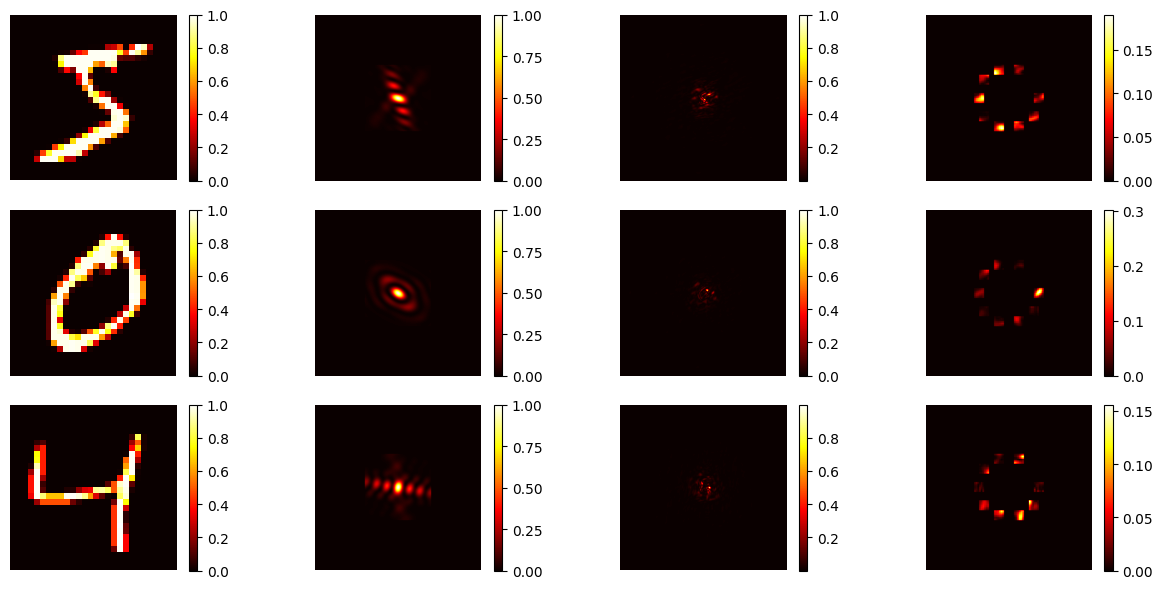

In [166]:
model.summary()
testImages = np.array([x_train[i] for i in [0,1,2]])
planes     = [0,4,5]
plotFields(model, testImages, planes,  detector[:-1],  zoom = 100)

# Using a lens
I implemented a lens as well which we could use instead of the numerical fft

In [181]:
# Choose Model parameters
lam  = 1
D    = 150                             # Here I define Everything in units of lambda, but real units can be used
N    = 2*D                             # Use 2 points per lambda for far-field propagation (more if you look at the near field o correctly show high frequency components)
x = y = np.linspace(-D/2, D/2, N)      # This defines the computational domain                   # make sure that the pixelsize is not smaller than the sampling, it is best to choose a common multiple to avoid any interpolation       

# Prepare input
N = len(x)
pad = int((N - 28) // 2)
padding = [[0, 0], [pad, pad], [pad, pad]]
input   = tf.pad(testImages, padding)



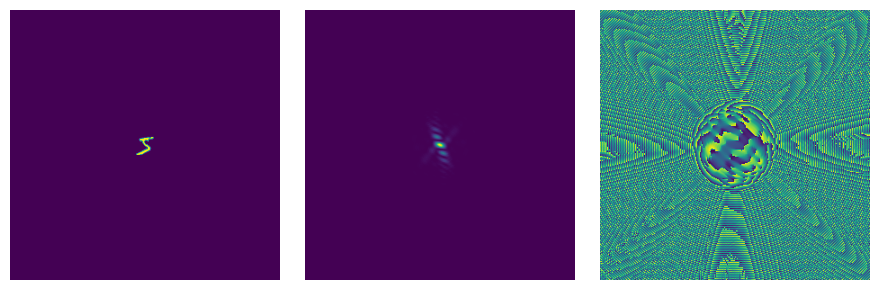

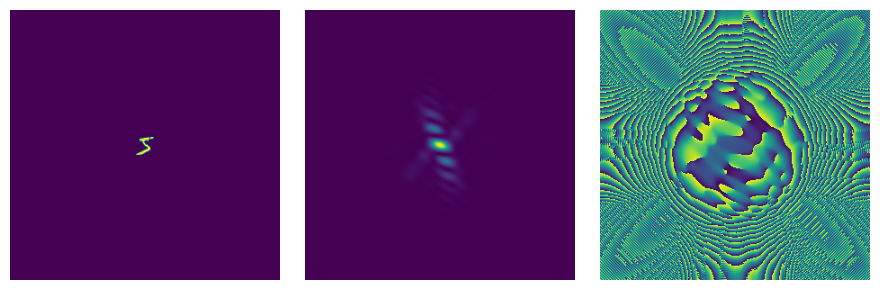

In [182]:
# Apply lens
f = 30
out = dnn.Lens(x=x, y=y, z1=f ,z2=f,f =f, lam=1 )(tf.cast(input, tf.complex64))
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(input[0])
axes[1].imshow(np.abs(out[0])**2)
axes[2].imshow(np.angle(out[0]))
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

# Apply lens
f = 60
out = dnn.Lens(x=x, y=y, z1=f ,z2=f,f =f, lam=1 )(tf.cast(input, tf.complex64))
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(input[0])
axes[1].imshow(np.abs(out[0])**2)
axes[2].imshow(np.angle(out[0]))
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

(3, 84, 84)


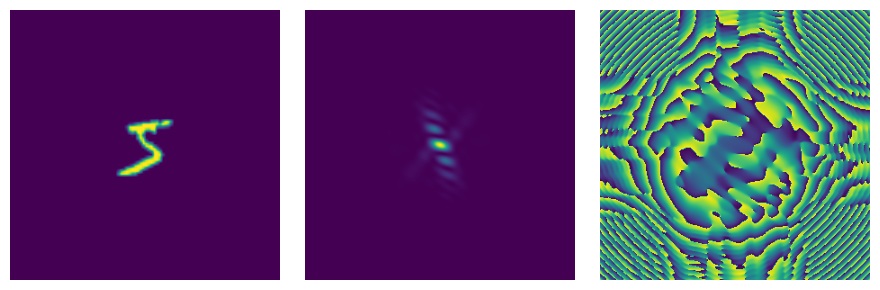

In [203]:
from scipy.ndimage import zoom

# Apply lens
f = 20
fac = 3
# Prepare input
N = len(x)
testimages_upscaled = zoom(testImages, (1, fac,fac), order=1) 
print(np.shape(testimages_upscaled ))
pad = int((N - 28*fac) // 2)
padding = [[0, 0], [pad, pad], [pad, pad]]
input   = tf.pad(testimages_upscaled, padding)

out = dnn.Lens(x=x/fac, y=y/fac, z1=f ,z2=f,f =f, lam=1 )(tf.cast(input, tf.complex64))
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(input[0])
axes[1].imshow(np.abs(out[0])**2)
axes[2].imshow(np.angle(out[0]))
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()


(3, 28, 28)


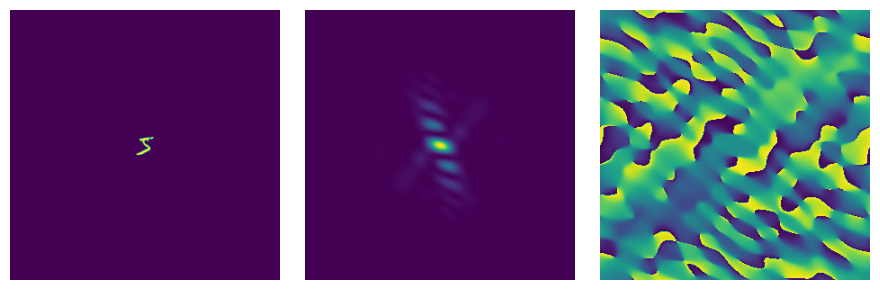

In [215]:
from scipy.ndimage import zoom

# Apply lens
f = 10
fac = 1
# Prepare input
N = len(x)
testimages_upscaled = zoom(testImages, (1, fac,fac), order=1) 
print(np.shape(testimages_upscaled ))
pad = int((N - 28*fac) // 2)
padding = [[0, 0], [pad, pad], [pad, pad]]
input   = tf.pad(testimages_upscaled, padding)

out = dnn.opticalFFT(x =x, y = y, lam = 1, f = None)(tf.cast(input, tf.complex64))
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(input[0])
axes[1].imshow(np.abs(out[0])**2)
axes[2].imshow(np.angle(out[0]))
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()
